# Embedding Generation
This example performs generation of a single embedding vector from a 16x16 Sentinel-2 RGB image patch with TerraMind.

In [13]:
from pathlib import Path

import torch
import rioxarray as rxr
from huggingface_hub import hf_hub_download
from terratorch.registry import BACKBONE_REGISTRY
import numpy as np

# Select device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

In [14]:
# build model
model = BACKBONE_REGISTRY.build(
    "terramind_v1_base",
    # modalities=["S2L2A"], # all S2 bands
    modalities=["S2RGB"], # S2 RGB bands
    pretrained=True,
)

model = model.to(device)

In [15]:
model.eval()

TerraMindViT(
  (encoder_embeddings): ModuleDict(
    (untok_sen2rgb@224): ImageEncoderEmbedding(
      (proj): Linear(in_features=768, out_features=768, bias=False)
    )
  )
  (encoder): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm()
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=False)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=False)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm()
      (mlp): GatedMlp(
        (fc1): Linear(in_features=768, out_features=2048, bias=False)
        (act): SiLU()
        (fc2): Linear(in_features=2048, out_features=768, bias=False)
        (fc3): Linear(in_features=768, out_features=2048, bias=False)
      )
    )
  )
  (encoder_norm): LayerNorm()
  (tokenizer): ModuleDict()
)

In [16]:
# Download image if necessary
image_path = Path('examples/S2L2A/Santiago.tif')
if not image_path.exists():
    hf_hub_download(repo_id='ibm-esa-geospatial/Examples', filename='S2L2A/Santiago.tif', repo_type='dataset', local_dir='examples/')

In [23]:
means={
  "S2L2A": [1390.458, 1503.317, 1718.197, 1853.910, 2199.100, 2779.975, 2987.011, 3083.234, 3132.220, 3162.988, 2424.884, 1857.648],
  "RGB": [87.271, 80.931, 66.667]
}
stds={
  "S2L2A": [2106.761, 2141.107, 2038.973, 2134.138, 2085.321, 1889.926, 1820.257, 1871.918, 1753.829, 1797.379, 1434.261, 1334.311],
  "RGB": [58.767, 47.663, 42.631],
}

In [24]:
def rgb_smooth_quantiles(array, tolerance=0.02, scaling=0.5, default=2000):
    """
    array: numpy array with dimensions [C, H, W]
    returns 0-1 scaled array
    """

    # Get scaling thresholds for smoothing the brightness
    limit_low, median, limit_high = np.quantile(array, q=[tolerance, 0.5, 1. - tolerance])
    limit_high = limit_high.clip(default)  # Scale only pixels above default value
    limit_low = limit_low.clip(0, 1000)  # Scale only pixels below 1000
    limit_low = np.where(median > default / 2, limit_low, 0)  # Make image only darker if it is not dark already

    # Smooth very dark and bright values using linear scaling
    array = np.where(array >= limit_low, array, limit_low + (array - limit_low) * scaling)
    array = np.where(array <= limit_high, array, limit_high + (array - limit_high) * scaling)

    # Update scaling params using a 10th of the tolerance for max value
    limit_low, limit_high = np.quantile(array, q=[tolerance/10, 1. - tolerance/10])
    limit_high = limit_high.clip(default, 20000)  # Scale only pixels above default value
    limit_low = limit_low.clip(0, 500)  # Scale only pixels below 500
    limit_low = np.where(median > default / 2, limit_low, 0)  # Make image only darker if it is not dark already

    # Scale data to 0-255
    array = (array - limit_low) / (limit_high - limit_low)

    return array


def s2_to_rgb(rgb):
    rgb = rgb_smooth_quantiles(rgb)
    rgb = (rgb * 255).round().clip(0, 255).astype(np.uint8)

    return rgb

In [31]:
# Open image
data = rxr.open_rasterio(image_path).values
# Select RGB image of dimension 16x16,, and normalisee with pre-computed values
data = data[[3,2,1], 0:16, 0:16]
data = s2_to_rgb(data)


data = ((data
        - np.array(means['RGB'])[:, None, None])/
          np.array(stds['RGB'])[:, None, None])
# data.shape

In [32]:
data.shape

(3, 16, 16)

In [33]:
#create torch input
input = torch.tensor(data, dtype=torch.float, device=device).unsqueeze(0)
input.shape

torch.Size([1, 3, 16, 16])

## Retrieve Embedding

In [34]:
# we evaluate the pretrained model on the embedding and retrieve the last layer
with torch.no_grad():
    embedding = model(input)[-1]
embedding = embedding.cpu().squeeze().numpy()

In [35]:
# print output embedding
embedding.shape

(768,)

In [36]:
embedding

array([-1.93958402e-01,  9.19276297e-01, -4.08806980e-01,  3.79835933e-01,
       -1.81965888e-01, -1.45334613e+00, -3.94651830e-01, -4.51911390e-01,
        4.98278320e-01, -2.36500740e+00,  9.93106961e-01,  2.38066003e-01,
       -5.26367903e-01, -4.29756075e-01,  1.45560646e+00,  9.51165929e-02,
        3.17805797e-01,  1.08066249e+00,  4.99762088e-01,  1.65914774e-01,
       -5.67919552e-01,  7.73795396e-02,  1.37637064e-01,  8.35323572e-01,
       -5.76988578e-01,  2.92416602e-01, -1.77553713e-01, -1.73730478e-01,
       -3.14858973e-01,  7.15360105e-01, -5.21816134e-01,  3.82892013e-01,
        4.56806533e-02, -3.21626425e-01,  4.03100513e-02, -7.68868506e-01,
       -2.05921918e-01,  8.57874826e-02,  7.47192085e-01, -8.23675215e-01,
        9.84136641e-01,  6.99951410e-01,  8.07791471e-01, -1.85456634e-01,
        2.45676279e-01, -4.29453135e-01,  7.35927522e-01, -2.96679676e-01,
       -5.21618068e-01, -5.77784717e-01, -8.68885070e-02,  2.51910150e-01,
        6.63519278e-02, -

In [37]:
import matplotlib.pylab as plt

(0.0, 768.0)

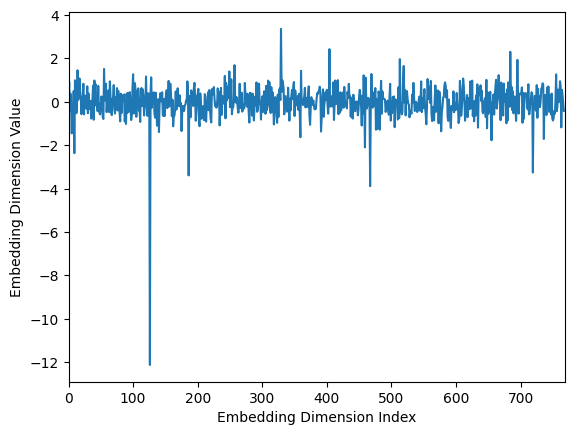

In [38]:
plt.plot(embedding)
plt.xlabel('Embedding Dimension Index')
plt.ylabel('Embedding Dimension Value')
plt.xlim([0, len(embedding)])